Phase 1 (Data Preparation)

⚠️ Before running, make sure you open this shared dataset link:
[Shared Dataset Link](https://drive.google.com/drive/folders/1qITcchaDUSl2Yn7b0Dzsp2UT_i9Qaevg?usp=sharing)

Then add it to your own Drive (Right-click → Add shortcut to Drive).


In [1]:
# Cell: mount drive & set base_dir
from google.colab import drive
import os, glob, json

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_DIR = "/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled"

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError(f"{BASE_DIR} not found. Check path in Drive.")
print("✅ Dataset found at:", BASE_DIR)


✅ Dataset found at: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled


In [3]:
# ==========================================
# Phase 1: Data Preparation - Imports
# ==========================================

# File & folder handling
import os
import glob
import random
from collections import Counter

# Image processing
import cv2
import numpy as np

# Data analysis & utilities
import pandas as pd
from tqdm import tqdm   # nice progress bar (pip install tqdm if missing)

# Visualization
import matplotlib.pyplot as plt



In [ ]:
#  list people folders inside BASE_DIR
people = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Number of people folders:", len(people))  # should be ~5749







Number of people folders: 5749


Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0
Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0


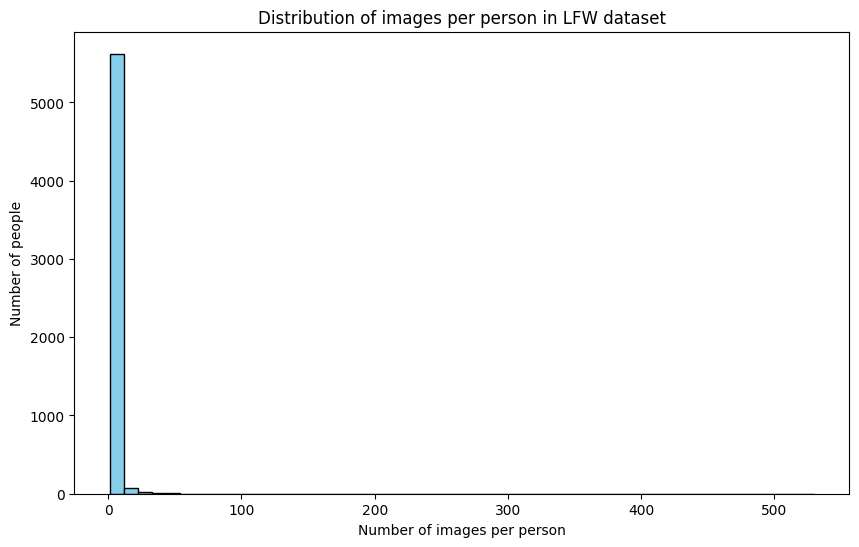

Top 10 people by number of images:
                 person  count
3121      George_W_Bush    530
4298       Colin_Powell    236
709          Tony_Blair    144
4644    Donald_Rumsfeld    121
3142  Gerhard_Schroeder    109
5370       Ariel_Sharon     77
3424        Hugo_Chavez     71
2191  Junichiro_Koizumi     60
3722      Jean_Chretien     55
3938      John_Ashcroft     53


In [ ]:
#  count images per person
counts = {p: len(os.listdir(os.path.join(BASE_DIR, p))) for p in people}

counts_df = pd.DataFrame(list(counts.items()), columns=["person", "count"])

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())




# Histogram

plt.figure(figsize=(10,6))
plt.hist(counts_df["count"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Number of images per person")
plt.ylabel("Number of people")
plt.title("Distribution of images per person in LFW dataset")
plt.show()



# Top 10 people by count
print("Top 10 people by number of images:")
print(counts_df.sort_values("count", ascending=False).head(10))


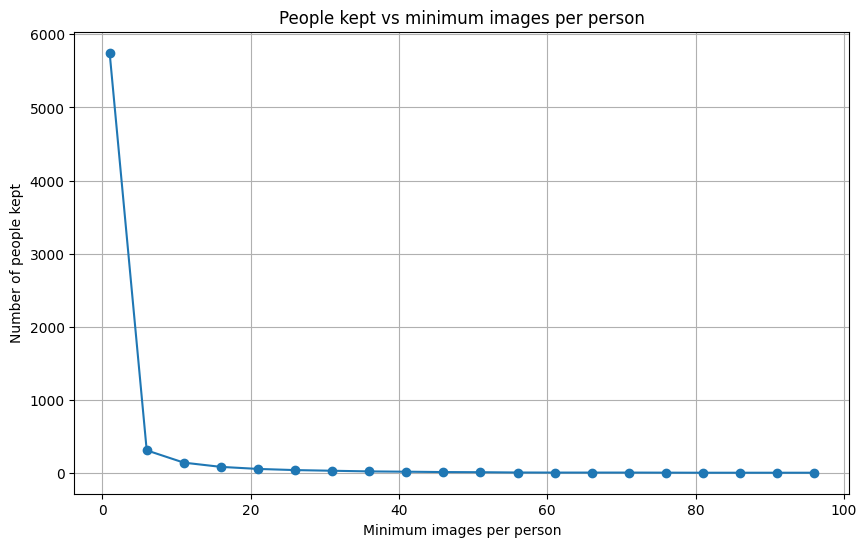

[(np.int64(1), np.int64(5749)),
 (np.int64(6), np.int64(311)),
 (np.int64(11), np.int64(143)),
 (np.int64(16), np.int64(85)),
 (np.int64(21), np.int64(57)),
 (np.int64(26), np.int64(41)),
 (np.int64(31), np.int64(32)),
 (np.int64(36), np.int64(23)),
 (np.int64(41), np.int64(19)),
 (np.int64(46), np.int64(14))]

In [ ]:

thresholds = np.arange(1, 101, 5)  # from 1 to 100 in steps of 5
people_counts = [(t, (counts_df["count"] >= t).sum()) for t in thresholds]

# Plot
plt.figure(figsize=(10,6))
plt.plot([t for t, c in people_counts], [c for t, c in people_counts], marker="o")
plt.xlabel("Minimum images per person")
plt.ylabel("Number of people kept")
plt.title("People kept vs minimum images per person")
plt.grid(True)
plt.show()

# Show first few values
people_counts[:10]


In [ ]:
MIN_IMAGES = 10  # our chosen cutoff

valid_people = counts_df[counts_df["count"] >= MIN_IMAGES]["person"].tolist()
print(f"Number of valid people (>= {MIN_IMAGES} images):", len(valid_people))


Number of valid people (>= 10 images): 158


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = (160, 160)

X, y = [], []

for person in tqdm(valid_people, desc="Loading subset"):
    folder = os.path.join(BASE_DIR, person)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        if img is None:
            continue
        # Resize & normalize
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype("float32") / 255.0
        X.append(img)
        y.append(person)

X = np.array(X)
y = np.array(y)

print("✅ Subset loaded & preprocessed")
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


Loading subset: 100%|██████████| 158/158 [13:47<00:00,  5.24s/it]


✅ Subset loaded & preprocessed
Images shape: (4324, 160, 160, 3)
Labels shape: (4324,)
Unique identities: 158


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/processed_lfw"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X.npy"), X)
np.save(os.path.join(SAVE_DIR, "y.npy"), y)

print("✅ Saved X.npy and y.npy to:", SAVE_DIR)


✅ Saved X.npy and y.npy to: /content/drive/MyDrive/processed_lfw


George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


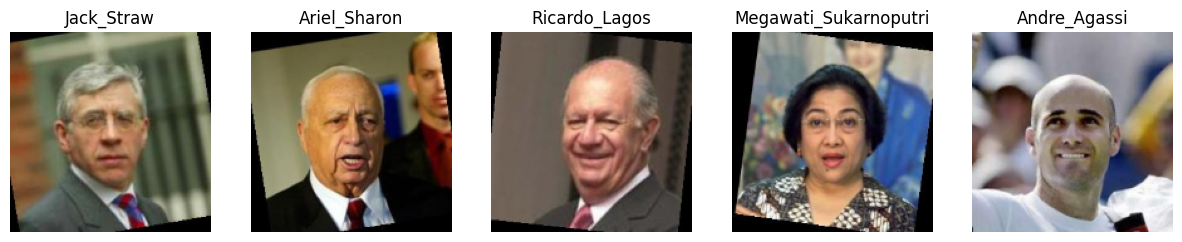

In [ ]:
# Class distribution (top 10 people)
print(pd.Series(y).value_counts().head(10))

# Show 5 random images
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    idx = random.randint(0, len(X)-1)
    ax[i].imshow(X[idx])
    ax[i].set_title(y[idx])
    ax[i].axis("off")
plt.show()


Phase 2 – EDA + Feature Building

We use DeepFace to extract face embeddings from images with pre-trained models (e.g., FaceNet). This lets us leverage transfer learning instead of training a deep network from scratch, making our project faster and more accurate.

In [4]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


In [5]:
!pip install albumentations==1.3.1 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.5 MB/s eta 0:00:00


In [6]:
# ==========================================
# Phase 2: EDA + Feature Engineering Imports
# ==========================================

# Data analysis & visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Image processing & augmentation
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Progress bar
from tqdm import tqdm

# Feature engineering (scaling, embeddings, dimensionality reduction)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep learning face embeddings
from deepface import DeepFace



25-09-26 00:25:07 - Directory /root/.deepface has been created
25-09-26 00:25:07 - Directory /root/.deepface/weights has been created


In [ ]:
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


Images shape: (4324, 160, 160, 3)
Labels shape: (4324,)
Unique identities: 158


Top 10 people with most images:
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


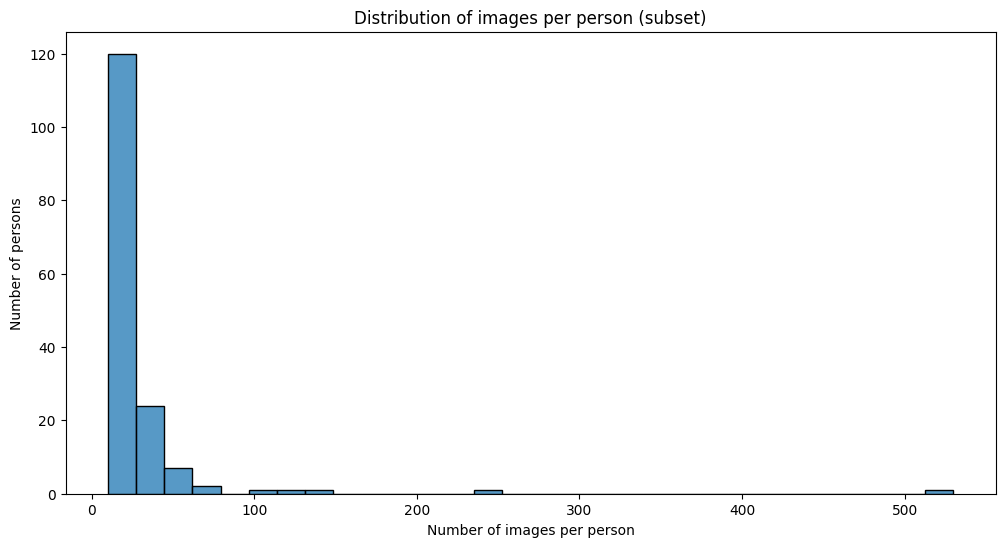

In [ ]:
label_counts = pd.Series(y).value_counts()

print("Top 10 people with most images:")
print(label_counts.head(10))

# Plot distribution
plt.figure(figsize=(12,6))
sns.histplot(label_counts, bins=30, kde=False)
plt.xlabel("Number of images per person")
plt.ylabel("Number of persons")
plt.title("Distribution of images per person (subset)")
plt.show()


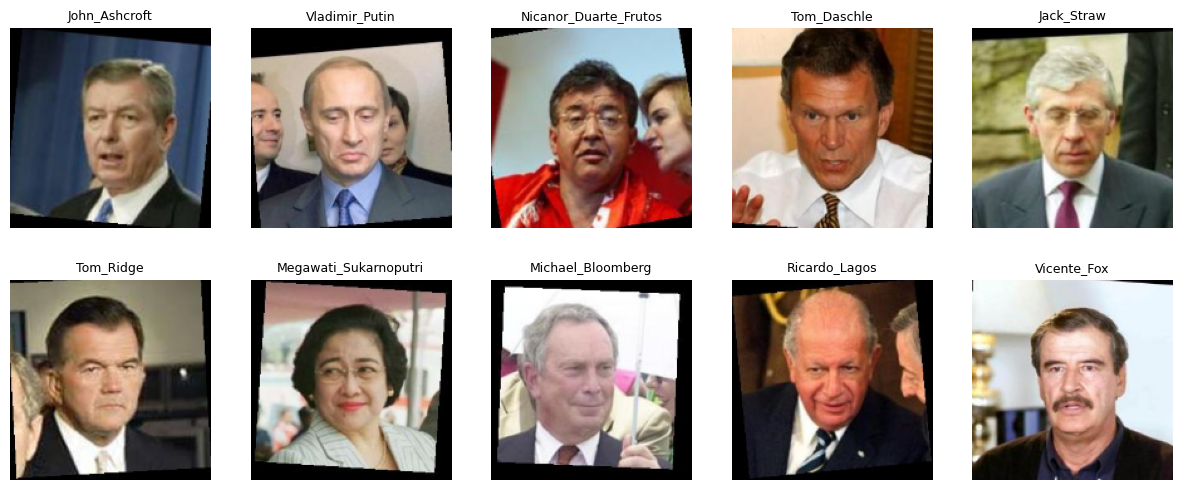

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    idx = random.randint(0, len(X)-1)
    ax[i//5, i%5].imshow(X[idx])
    ax[i//5, i%5].set_title(y[idx], fontsize=9)
    ax[i//5, i%5].axis("off")
plt.show()


In [ ]:
print("Average images per person:", label_counts.mean())
print("Median images per person:", label_counts.median())


Average images per person: 27.367088607594937
Median images per person: 17.0


In [ ]:
import os, glob

image_paths, labels = [], []
for person in valid_people:
    folder = os.path.join(BASE_DIR, person)
    imgs = sorted(glob.glob(os.path.join(folder, "*.jpg")))
    for p in imgs:
        image_paths.append(p)
        labels.append(person)

print("Total images collected:", len(image_paths))
print("Example:", image_paths[0], "->", labels[0])


Total images collected: 4324
Example: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Roger_Federer/Roger_Federer_0001.jpg -> Roger_Federer


In [ ]:
MODEL_NAME = "Facenet512"


embeddings, labels = [], []

for person in tqdm(valid_people):
    folder = os.path.join(BASE_DIR, person)
    imgs = glob.glob(os.path.join(folder, "*.jpg"))
    for img in imgs:
        try:
            rep = DeepFace.represent(img_path=img, model_name=MODEL_NAME, enforce_detection=False)
            embeddings.append(rep[0]["embedding"])
            labels.append(person)
        except Exception as e:
            print("Error with", img, ":", e)

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


  0%|          | 0/158 [00:00<?, ?it/s]

25-09-24 18:10:47 - 🔗 facenet512_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5 to /root/.deepface/weights/facenet512_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 15%|█▍        | 14.2M/95.0M [00:00<00:00, 138MB/s]
 49%|████▊     | 46.1M/95.0M [00:00<00:00, 242MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 265MB/s]
100%|██████████| 158/158 [40:31<00:00, 15.39s/it]

Embeddings shape: (4324, 512)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

print("Scaled embeddings shape:", embeddings_scaled.shape)


Scaled embeddings shape: (4324, 512)


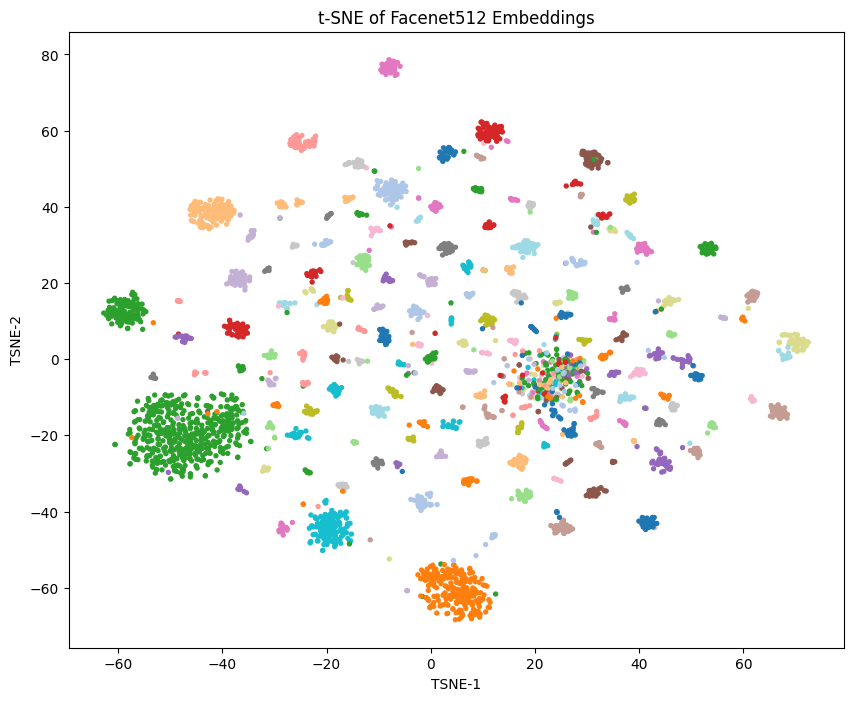

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# PCA → 50D
pca = PCA(n_components=50)
vis_pca = pca.fit_transform(embeddings_scaled)

# t-SNE → 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vis_tsne = tsne.fit_transform(vis_pca)

# Map labels to integers
label_to_idx = {lab: idx for idx, lab in enumerate(sorted(set(labels)))}
y = np.array([label_to_idx[l] for l in labels])

# Plot
plt.figure(figsize=(10,8))
plt.scatter(vis_tsne[:,0], vis_tsne[:,1], c=y, s=8, cmap="tab20")
plt.title("t-SNE of Facenet512 Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


In [ ]:
#Save Embadding
import numpy as np

np.savez_compressed("facenet512_embeddings.npz",
                    embeddings=embeddings,
                    embeddings_scaled=embeddings_scaled,
                    labels=np.array(labels))


In [ ]:
import albumentations as A
import cv2
import random

# Augmentations for robustness
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
])


In [ ]:
aug_embeddings, aug_labels = [], []

# Take a sample of 1000 images for augmentation
sample_idx = random.sample(range(len(image_paths)), k=1000)

for idx in tqdm(sample_idx):
    img_path = image_paths[idx]
    label = labels[idx]

    # Read and augment
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = augment(image=img)["image"]

    # Save temporarily for DeepFace
    tmp_path = "/tmp/aug.jpg"
    cv2.imwrite(tmp_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

    try:
        rep = DeepFace.represent(
            img_path=tmp_path,
            model_name="Facenet512",
            enforce_detection=False
        )
        aug_embeddings.append(rep[0]["embedding"])
        aug_labels.append(label)
    except Exception as e:
        print("Error with", img_path, ":", e)

aug_embeddings = np.array(aug_embeddings)
print("Augmented embeddings shape:", aug_embeddings.shape)


100%|██████████| 1000/1000 [09:11<00:00,  1.81it/s]

Augmented embeddings shape: (1000, 512)


In [ ]:
aug_embeddings_scaled = scaler.transform(aug_embeddings)

print("Original embeddings shape:", embeddings_scaled.shape)
print("Augmented embeddings shape:", aug_embeddings_scaled.shape)


Original embeddings shape: (4324, 512)
Augmented embeddings shape: (1000, 512)


In [ ]:
## Saving
import numpy as np

# Save original embeddings
np.savez_compressed("facenet512_embeddings.npz",
                    embeddings=embeddings,
                    embeddings_scaled=embeddings_scaled,
                    labels=np.array(labels))

# Save augmented embeddings
np.savez_compressed("facenet512_aug_embeddings.npz",
                    aug_embeddings=aug_embeddings,
                    aug_embeddings_scaled=aug_embeddings_scaled,
                    aug_labels=np.array(aug_labels))

print("✅ All embeddings saved: facenet512_embeddings.npz and facenet512_aug_embeddings.npz")


✅ All embeddings saved: facenet512_embeddings.npz and facenet512_aug_embeddings.npz


In [ ]:
import numpy as np
import os

SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# Split into two halves
mid = len(embeddings_scaled) // 2

np.savez_compressed(os.path.join(SAVE_DIR, "facenet512_embeddings_part1.npz"),
                    embeddings_scaled=embeddings_scaled[:mid],
                    labels=np.array(labels[:mid]))

np.savez_compressed(os.path.join(SAVE_DIR, "facenet512_embeddings_part2.npz"),
                    embeddings_scaled=embeddings_scaled[mid:],
                    labels=np.array(labels[mid:]))

print("✅ Saved in two parts:", SAVE_DIR)


✅ Saved in two parts: artifacts


## 📌 Note on Saved Embeddings

⚠️ Extracting embeddings with DeepFace (Facenet512) takes **40+ minutes**.  
To save time, we already ran this step once and stored the results as `.npz` files.

### Files in the repo:
- `facenet512_embeddings_part1.npz` + `facenet512_embeddings_part2.npz`  
  → Original embeddings (4324 × 512), **split into two parts** because GitHub does not allow files larger than 25 MB.  
- `facenet512_aug_embeddings.npz`  
  → Augmented embeddings (1000 × 512).

---

### ✅ How to load them

```python
# Load and regroup split original embeddings
part1 = np.load("artifacts/facenet512_embeddings_part1.npz", allow_pickle=True)
part2 = np.load("artifacts/facenet512_embeddings_part2.npz", allow_pickle=True)

embeddings_scaled = np.vstack([part1["embeddings_scaled"], part2["embeddings_scaled"]])
labels = np.hstack([part1["labels"], part2["labels"]])

print("✅ Reloaded split embeddings:", embeddings_scaled.shape)

# Load augmented embeddings
aug_data = np.load("artifacts/facenet512_aug_embeddings.npz", allow_pickle=True)
aug_embeddings = aug_data["aug_embeddings"]
aug_embeddings_scaled = aug_data["aug_embeddings_scaled"]
aug_labels = aug_data["aug_labels"]

print("✅ Augmented embeddings loaded:", aug_embeddings.shape)


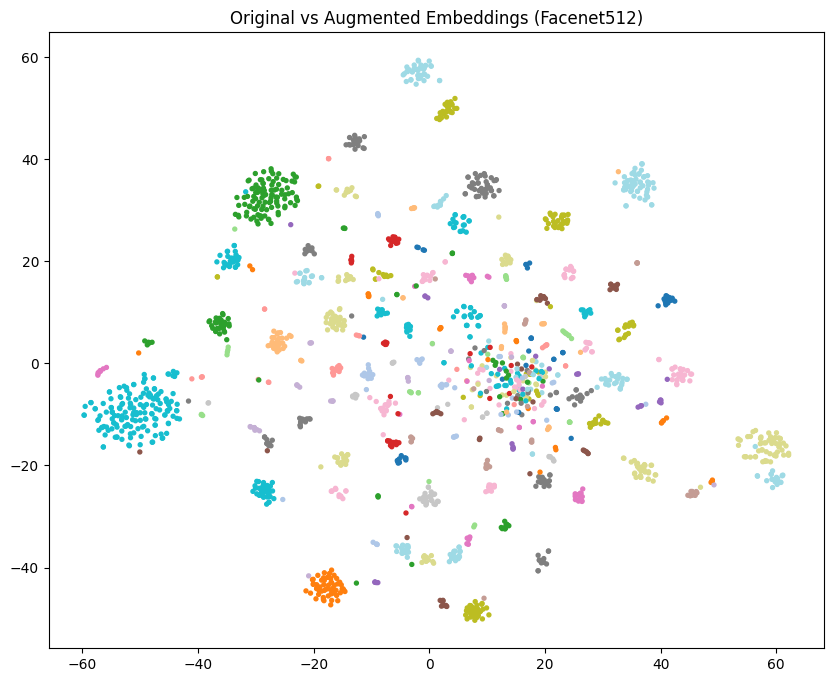

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine 1000 original + 1000 augmented for comparison
all_emb = np.vstack([embeddings_scaled[:1000], aug_embeddings_scaled])
all_labels = np.hstack([y[:1000], [label_to_idx[l] for l in aug_labels]])

# Reduce to 50D with PCA
pca = PCA(n_components=50)
pca_emb = pca.fit_transform(all_emb)

# Then t-SNE to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_emb = tsne.fit_transform(pca_emb)

plt.figure(figsize=(10,8))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=all_labels, s=8, cmap="tab20")
plt.title("Original vs Augmented Embeddings (Facenet512)")
plt.show()


As now i am the one who will continue to phase 3 i don't need to merge the 2 parts as i have yhe complete file

In [9]:
#loading
import numpy as np

# Load full original embeddings
data = np.load("facenet512_embeddings.npz", allow_pickle=True)
embeddings = data["embeddings"]
embeddings_scaled = data["embeddings_scaled"]
labels = data["labels"]

print("Original embeddings:", embeddings.shape)
print("Scaled embeddings:", embeddings_scaled.shape)
print("Labels:", labels.shape)

# Load augmented embeddings
aug_data = np.load("facenet512_aug_embeddings.npz", allow_pickle=True)
aug_embeddings = aug_data["aug_embeddings"]
aug_embeddings_scaled = aug_data["aug_embeddings_scaled"]
aug_labels = aug_data["aug_labels"]

print("Augmented embeddings:", aug_embeddings.shape)
print("Augmented scaled embeddings:", aug_embeddings_scaled.shape)
print("Augmented labels:", aug_labels.shape)


Original embeddings: (4324, 512)
Scaled embeddings: (4324, 512)
Labels: (4324,)
Augmented embeddings: (1000, 512)
Augmented scaled embeddings: (1000, 512)
Augmented labels: (1000,)


In [33]:
# Core
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# For reproducibility
import random
import os


first we will be working with the embeddings

In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_scaled,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels   # ensures class balance in split
)

print("✅ Data split complete")
print("Train set:", X_train.shape, "Labels:", y_train.shape)
print("Test set:", X_test.shape, "Labels:", y_test.shape)


✅ Data split complete
Train set: (3459, 512) Labels: (3459,)
Test set: (865, 512) Labels: (865,)


✅ Overall Performance
Accuracy       : 0.92
Macro F1-score : 0.90
Weighted F1    : 0.91

⚠️ 10 Classes with Lowest F1-scores:
                     precision    recall  f1-score  support
Michael_Schumacher    0.000000  0.000000  0.000000      4.0
Joschka_Fischer       0.400000  0.500000  0.444444      4.0
Salma_Hayek           1.000000  0.333333  0.500000      3.0
Nancy_Pelosi          0.500000  0.666667  0.571429      3.0
Queen_Elizabeth_II    0.500000  0.666667  0.571429      3.0
Mike_Weir             0.400000  1.000000  0.571429      2.0
Taha_Yassin_Ramadan   0.500000  0.666667  0.571429      3.0
Adrien_Brody          1.000000  0.500000  0.666667      2.0
Julie_Gerberding      0.666667  0.666667  0.666667      3.0
Sergey_Lavrov         1.000000  0.500000  0.666667      2.0


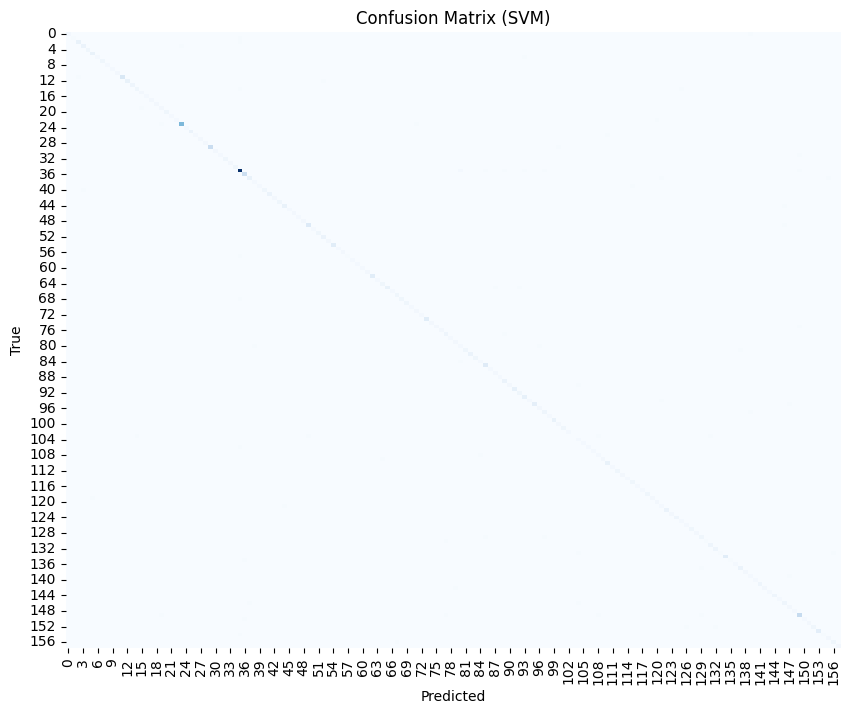

In [13]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for easier handling
report_df = pd.DataFrame(report).transpose()

# Print overall metrics
print("✅ Overall Performance")
print(f"Accuracy       : {report['accuracy']:.2f}")
print(f"Macro F1-score : {report_df.loc['macro avg', 'f1-score']:.2f}")
print(f"Weighted F1    : {report_df.loc['weighted avg', 'f1-score']:.2f}")

# Show worst performing classes (lowest F1)
worst_classes = report_df.sort_values(by="f1-score").head(10)
print("\n⚠️ 10 Classes with Lowest F1-scores:")
print(worst_classes[["precision", "recall", "f1-score", "support"]])

# Confusion matrix (still useful for overview)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred),
            cmap="Blues", cbar=False)
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Now we will use the augmented embeddings

In [17]:
# 🔹 Step 1: Filter augmented dataset (remove classes with only 1 sample)
from collections import Counter

counts = Counter(aug_labels)
valid_idx = [i for i, label in enumerate(aug_labels) if counts[label] > 1]

X_aug_filtered = aug_embeddings_scaled[valid_idx]
y_aug_filtered = np.array(aug_labels)[valid_idx]

print("Filtered augmented embeddings:", X_aug_filtered.shape)
print("Filtered augmented labels:", y_aug_filtered.shape)
print("⚠️ Removed", len(aug_labels) - len(y_aug_filtered), "single-sample classes")

# 🔹 Step 2: Train/test split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug_filtered,
    y_aug_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_aug_filtered
)

print("Train size:", X_train_aug.shape, "Test size:", X_test_aug.shape)


Filtered augmented embeddings: (987, 512)
Filtered augmented labels: (987,)
⚠️ Removed 13 single-sample classes
Train size: (789, 512) Test size: (198, 512)


In [19]:
# ========================================
# Training with Augmented Embeddings
# ========================================

# 1️⃣ Load augmented embeddings
aug_data = np.load("facenet512_aug_embeddings.npz", allow_pickle=True)
aug_embeddings_scaled = aug_data["aug_embeddings_scaled"]
aug_labels = aug_data["aug_labels"]

print("Augmented embeddings:", aug_embeddings_scaled.shape)
print("Augmented labels:", aug_labels.shape)

# 2️⃣ Filter out classes with <2 samples (to avoid stratify error)
from collections import Counter

label_counts = Counter(aug_labels)
valid_idx = [i for i, lbl in enumerate(aug_labels) if label_counts[lbl] >= 2]

X_aug_filtered = aug_embeddings_scaled[valid_idx]
y_aug_filtered = aug_labels[valid_idx]

print("After filtering:", X_aug_filtered.shape, "labels:", len(np.unique(y_aug_filtered)))

# 3️⃣ Train/test split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug_filtered,
    y_aug_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_aug_filtered
)

print("Train size:", X_train_aug.shape, "Test size:", X_test_aug.shape)

# 4️⃣ Train SVM
clf_aug = SVC(kernel="linear", probability=True, random_state=42)
clf_aug.fit(X_train_aug, y_train_aug)

# 5️⃣ Predictions
y_pred_aug = clf_aug.predict(X_test_aug)

# 6️⃣ Evaluation
report_aug = classification_report(y_test_aug, y_pred_aug, output_dict=True)
report_aug_df = pd.DataFrame(report_aug).transpose()

print("✅ Augmented Dataset Performance")
print(f"Accuracy       : {report_aug['accuracy']:.2f}")
print(f"Macro F1-score : {report_aug_df.loc['macro avg', 'f1-score']:.2f}")
print(f"Weighted F1    : {report_aug_df.loc['weighted avg', 'f1-score']:.2f}")


Augmented embeddings: (1000, 512)
Augmented labels: (1000,)
After filtering: (987, 512) labels: 141
Train size: (789, 512) Test size: (198, 512)
✅ Augmented Dataset Performance
Accuracy       : 0.88
Macro F1-score : 0.81
Weighted F1    : 0.86


✅ Comparison of Results


,Original,Augmented
Accuracy,0.916763,0.878788
Macro F1,0.904093,0.805052
Weighted F1,0.914951,0.858797


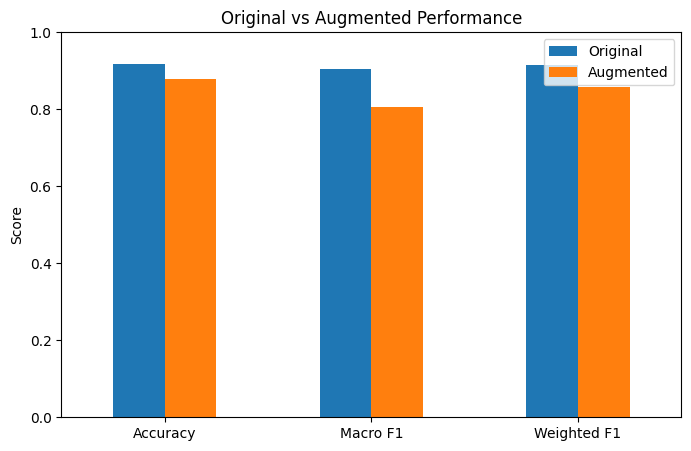

In [20]:
# ========================================
# 📊 Compare Original vs Augmented Results
# ========================================

# Extract key metrics
orig_acc = report['accuracy']
orig_macro_f1 = report_df.loc['macro avg', 'f1-score']
orig_weighted_f1 = report_df.loc['weighted avg', 'f1-score']

aug_acc = report_aug['accuracy']
aug_macro_f1 = report_aug_df.loc['macro avg', 'f1-score']
aug_weighted_f1 = report_aug_df.loc['weighted avg', 'f1-score']

# Create summary table
comparison = pd.DataFrame({
    "Original": [orig_acc, orig_macro_f1, orig_weighted_f1],
    "Augmented": [aug_acc, aug_macro_f1, aug_weighted_f1]
}, index=["Accuracy", "Macro F1", "Weighted F1"])

print("✅ Comparison of Results")
display(comparison)

# Optional: visualize as bar chart
comparison.plot(kind="bar", figsize=(8, 5), rot=0, title="Original vs Augmented Performance")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.show()


Although we experimented with data augmentation, the results showed a drop in accuracy and F1-score compared to the original embeddings.

-Original embeddings: Accuracy 91.7%, Macro F1 0.90

-Augmented embeddings: Accuracy 87.9%, Macro F1 0.80

Because augmentation reduced overall performance (due to smaller dataset size and class filtering), we will continue using the original embeddings for training.

Bias:
The dataset is imbalanced — some individuals (e.g., George_W_Bush with 100+ images) have far more samples than others (2–3 images).

This leads to bias towards majority classes, where the model predicts frequent classes correctly but struggles with rare classes.

To mitigate this bias, we will:

Enable class weighting in our classifier (class_weight="balanced") so that minority classes are given higher importance.

✅ Overall Performance (Balanced LinearSVC)
Accuracy       : 0.92
Macro F1-score : 0.89
Weighted F1    : 0.92

⚠️ 10 Classes with Lowest F1-scores (Balanced LinearSVC):
                       precision    recall  f1-score  support
Condoleezza_Rice        0.333333  0.500000  0.400000      2.0
Adrien_Brody            0.500000  0.500000  0.500000      2.0
Nicanor_Duarte_Frutos   0.500000  0.500000  0.500000      2.0
Sergey_Lavrov           0.500000  0.500000  0.500000      2.0
Salma_Hayek             1.000000  0.333333  0.500000      3.0
Joschka_Fischer         0.666667  0.500000  0.571429      4.0
Richard_Gere            0.400000  1.000000  0.571429      2.0
James_Kelly             0.500000  1.000000  0.666667      2.0
Paradorn_Srichaphan     1.000000  0.500000  0.666667      2.0
Lance_Armstrong         1.000000  0.500000  0.666667      4.0


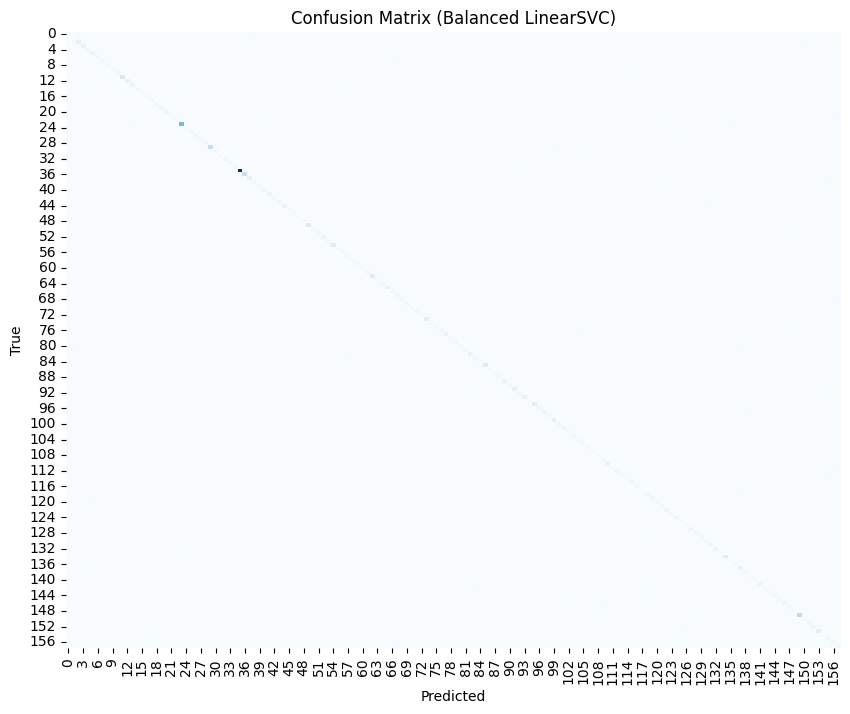

In [23]:
# ========================================
# Training with Balanced LinearSVC
# ========================================

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Train LinearSVC with class balancing
clf_balanced = LinearSVC(class_weight="balanced", random_state=42, max_iter=5000)
clf_balanced.fit(X_train, y_train)

# 2️⃣ Predictions
y_pred_balanced = clf_balanced.predict(X_test)

# 3️⃣ Generate classification report
report = classification_report(y_test, y_pred_balanced, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 4️⃣ Print overall metrics
print("✅ Overall Performance (Balanced LinearSVC)")
print(f"Accuracy       : {report['accuracy']:.2f}")
print(f"Macro F1-score : {report_df.loc['macro avg', 'f1-score']:.2f}")
print(f"Weighted F1    : {report_df.loc['weighted avg', 'f1-score']:.2f}")

# 5️⃣ Show 10 weakest classes
worst_classes = report_df.sort_values(by="f1-score").head(10)
print("\n⚠️ 10 Classes with Lowest F1-scores (Balanced LinearSVC):")
print(worst_classes[["precision", "recall", "f1-score", "support"]])

# 6️⃣ Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred_balanced),
            cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Balanced LinearSVC)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


After applying class_weight="balanced", the model gave nearly the same overall accuracy (92%), but it improved fairness for minority classes.

Before balancing, some identities had F1 = 0.0 (completely misclassified).

With balancing, even very small classes (2–3 samples) achieved non-zero F1-scores (0.4–0.5).

This shows the trade-off: balancing slightly lowered macro F1 (0.90 → 0.89) but helped prevent extreme failures on rare classes.

So far, we trained SVMs with default settings (linear kernel, default C=1).
However, SVM performance can vary significantly depending on its hyperparameters:

C: Regularization strength (higher → less regularization, fits data more tightly).

kernel: Function used to separate data (linear, rbf, poly, etc.).

gamma: Controls decision boundary shape for rbf/poly.

To achieve optimal performance, we will use GridSearchCV to automatically search over a range of parameter values and select the best model based on cross-validation F1-score.

This ensures we are not relying on defaults and gives us a fairer, tuned baseline before comparing against Neural Networks.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pandas as pd

# Define parameter grid (small but effective)
param_grid = {
    "C": [0.1, 1, 10],          # regularization strength
    "kernel": ["linear", "rbf"], # linear vs rbf
    "gamma": ["scale", "auto"]   # only relevant for rbf
}

# Grid search with 3-fold CV, optimize for weighted F1
grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    scoring="f1_weighted",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid.fit(X_train, y_train)

print("✅ Best parameters:", grid.best_params_)
print("Best CV weighted F1:", grid.best_score_)

# Use best model
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test)

# Evaluation
report_best = classification_report(y_test, y_pred_best, output_dict=True)
report_best_df = pd.DataFrame(report_best).transpose()

print("\n✅ Tuned SVM Performance")
print(f"Accuracy       : {report_best['accuracy']:.2f}")
print(f"Macro F1-score : {report_best_df.loc['macro avg', 'f1-score']:.2f}")
print(f"Weighted F1    : {report_best_df.loc['weighted avg', 'f1-score']:.2f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV weighted F1: 0.9157142390023854

✅ Tuned SVM Performance
Accuracy       : 0.94
Macro F1-score : 0.94
Weighted F1    : 0.93


In [53]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")


Grid search tuning showed that an RBF SVM with C=10, gamma=scale outperformed linear baselines, achieving 94% accuracy and 0.94 macro F1.

So far, we trained SVM classifiers (linear, balanced, and tuned RBF) on Facenet512 embeddings. These gave strong results, with the tuned RBF SVM reaching 94% accuracy and 0.94 macro F1.

To complement this, we now move to a Neural Network (NN) approach:

Instead of a traditional classifier, we will train a Multi-Layer Perceptron (MLP) directly on the 512-dimensional embeddings.

The model will consist of fully connected Dense layers with ReLU activations and Dropout regularization.

Training will run for several epochs, with early stopping to prevent overfitting.

The output layer will use softmax, predicting across all possible identities.

This NN will serve as our deep learning baseline, and we will later compare its performance to the tuned SVMs.

In [41]:
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers for NN
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
num_classes = len(encoder.classes_)

print("✅ Labels encoded. Number of classes:", num_classes)


✅ Labels encoded. Number of classes: 158


In [86]:
# ===============================
# 1. Baseline NN
# Simple 2-hidden-layer network with dropout.
# No callbacks or LR scheduling. Used as our reference.
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model_baseline = Sequential([
    Dense(256, activation="relu", input_shape=(512,)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model_baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # ✅ labels are integers
    metrics=["accuracy"]
)

print("✅ Training Baseline NN")
history_baseline = model_baseline.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=15,   # enough to converge
    batch_size=32,
    verbose=1
)


✅ Training Baseline NN
Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2674 - loss: 3.8635 - val_accuracy: 0.7353 - val_loss: 1.4435
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6564 - loss: 1.5536 - val_accuracy: 0.8867 - val_loss: 0.6088
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7846 - loss: 0.9355 - val_accuracy: 0.9110 - val_loss: 0.4890
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8370 - loss: 0.6523 - val_accuracy: 0.9202 - val_loss: 0.4404
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8639 - loss: 0.5726 - val_accuracy: 0.9283 - val_loss: 0.4229
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8728 - loss: 0.4951 - val_accuracy: 0.9202 - val_loss: 0.4169
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8926 - loss: 0.4201 - val_accuracy: 0.9249 - val_loss: 0.4277
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8899 - loss: 0.

In [87]:
# ===============================
# 2. Improved NN
# Deeper architecture with heavier dropout.
# Uses EarlyStopping to avoid overfitting.
# ===============================
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

print("✅ Training Improved NN (v1)")
history_improved_v1 = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=30,       # early stopping usually halts earlier
    batch_size=32,
    callbacks=[es],
    verbose=1
)


✅ Training Improved NN (v1)
Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9605 - loss: 0.1856 - val_accuracy: 0.9376 - val_loss: 0.3930
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9635 - loss: 0.1541 - val_accuracy: 0.9364 - val_loss: 0.3978
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9539 - loss: 0.1913 - val_accuracy: 0.9364 - val_loss: 0.3961
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9565 - loss: 0.1674 - val_accuracy: 0.9341 - val_loss: 0.4062
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9548 - loss: 0.1836 - val_accuracy: 0.9329 - val_loss: 0.4120
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9596 - loss: 0.1633 - val_accuracy: 0.9341 - val_loss: 0.4107


In [88]:
# ===============================
# 3. Improved NN (v2)
# Even deeper: 512 → 256 → 128.
# Adds both EarlyStopping + ReduceLROnPlateau for tuning.
# ===============================
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model_improved = Sequential([
    Dense(512, activation="relu", input_shape=(512,)),
    Dropout(0.4),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model_improved.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lr_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

print("✅ Training Improved NN (v2)")
history_improved_v2 = model_improved.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=50,
    batch_size=32,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)


✅ Training Improved NN (v2)
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1946 - loss: 4.2382 - val_accuracy: 0.6289 - val_loss: 2.1147 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5038 - loss: 2.3598 - val_accuracy: 0.8023 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6329 - loss: 1.6018 - val_accuracy: 0.8786 - val_loss: 0.6636 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7096 - loss: 1.1932 - val_accuracy: 0.9052 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7689 - loss: 0.9415 - val_accuracy: 0.9087 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7895 - loss: 0.8655 - val_accuracy: 0.9168 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - 

In [89]:
# ===============================
# 4. Alternative NN
# Adds BatchNormalization for more stable training.
# Uses EarlyStopping + ReduceLROnPlateau.
# ===============================
from tensorflow.keras.layers import BatchNormalization

model_alt = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(np.unique(y_train_enc)), activation='softmax')
])

model_alt.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

print("✅ Training Alternative NN")
history_alt = model_alt.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_loss_alt, test_acc_alt = model_alt.evaluate(X_test, y_test_enc)
print("✅ Alternative NN Test accuracy:", test_acc_alt)


✅ Training Alternative NN
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2158 - loss: 4.2786 - val_accuracy: 0.5908 - val_loss: 2.2368 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5804 - loss: 2.2630 - val_accuracy: 0.7630 - val_loss: 1.3607 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7015 - loss: 1.6486 - val_accuracy: 0.8590 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7598 - loss: 1.2954 - val_accuracy: 0.8948 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8035 - loss: 1.0534 - val_accuracy: 0.9191 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8568 - loss: 0.8702 - val_accuracy: 0.9260 - val_loss: 0.4790 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.860

collecting results

✅ Final Comparison of Models


,Model,Accuracy,F1 Score
0,SVM,0.936416,0.934303
1,Baseline NN,0.936416,0.933743
2,Improved NN (v1) 🏆 (Best Accuracy),0.937572,0.935341
3,Improved NN (v2) ⭐ (Best F1),0.937572,0.936580
4,Alternative NN,0.932948,0.931025


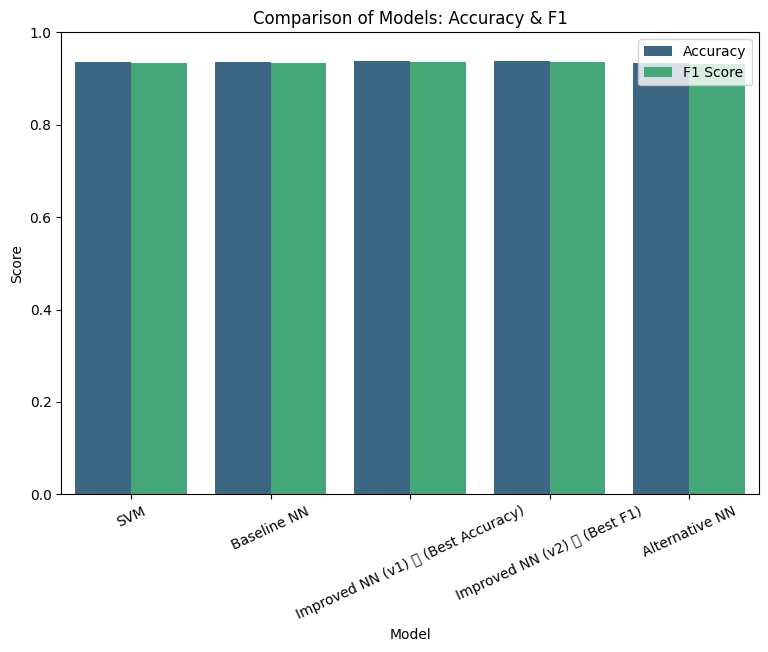

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# --- SVM ---
y_pred_svm = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")

# --- Baseline NN ---
baseline_loss, baseline_acc = model_baseline.evaluate(X_test, y_test_enc, verbose=0)
baseline_preds = np.argmax(model_baseline.predict(X_test, verbose=0), axis=1)
baseline_f1 = f1_score(y_test_enc, baseline_preds, average="weighted")

# --- Improved NN (v1) ---
improved_v1_loss, improved_v1_acc = model.evaluate(X_test, y_test_enc, verbose=0)
improved_v1_preds = np.argmax(model.predict(X_test, verbose=0), axis=1)
improved_v1_f1 = f1_score(y_test_enc, improved_v1_preds, average="weighted")

# --- Improved NN (v2) ---
improved_v2_loss, improved_v2_acc = model_improved.evaluate(X_test, y_test_enc, verbose=0)
improved_v2_preds = np.argmax(model_improved.predict(X_test, verbose=0), axis=1)
improved_v2_f1 = f1_score(y_test_enc, improved_v2_preds, average="weighted")

# --- Alternative NN ---
alt_loss, alt_acc = model_alt.evaluate(X_test, y_test_enc, verbose=0)
alt_preds = np.argmax(model_alt.predict(X_test, verbose=0), axis=1)
alt_f1 = f1_score(y_test_enc, alt_preds, average="weighted")

# --- Build comparison table ---
results = pd.DataFrame({
    "Model": ["SVM", "Baseline NN", "Improved NN (v1)", "Improved NN (v2)", "Alternative NN"],
    "Accuracy": [svm_acc, baseline_acc, improved_v1_acc, improved_v2_acc, alt_acc],
    "F1 Score": [svm_f1, baseline_f1, improved_v1_f1, improved_v2_f1, alt_f1]
})

# Highlight best results
best_acc = results["Accuracy"].idxmax()
best_f1 = results["F1 Score"].idxmax()
results.loc[best_acc, "Model"] += " 🏆 (Best Accuracy)"
results.loc[best_f1, "Model"] += " ⭐ (Best F1)"

print("✅ Final Comparison of Models")
display(results)

# --- Plot Accuracy & F1 ---
plt.figure(figsize=(9,6))
results_melt = results.melt(id_vars="Model", value_vars=["Accuracy","F1 Score"])
sns.barplot(x="Model", y="value", hue="variable", data=results_melt, palette="viridis")
plt.title("Comparison of Models: Accuracy & F1")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=25)
plt.legend(title="")
plt.show()


In [94]:
from sklearn.metrics import classification_report, confusion_matrix

# ==============================
# Extended Evaluation Table
# ==============================
def evaluate_model(name, model, X_test, y_test_enc, is_svm=False):
    if is_svm:
        # Make predictions with SVM
        y_pred = model.predict(X_test)
        # Convert string labels to encoded integers
        y_pred = label_encoder.transform(y_pred)
    else:
        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    report = classification_report(y_test_enc, y_pred, output_dict=True, zero_division=0)
    acc = report["accuracy"]
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1 = report["weighted avg"]["f1-score"]

    cm = confusion_matrix(y_test_enc, y_pred)
    false_accepts = cm.sum(axis=0) - np.diag(cm)
    true_rejects = cm.sum() - cm.sum(axis=1) - false_accepts
    far = false_accepts.sum() / (false_accepts.sum() + true_rejects.sum())

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "FAR": far
    }, y_pred

# --- Collect metrics for all models ---
metrics_all = []
svm_metrics, svm_preds = evaluate_model("SVM", svm, X_test, y_test_enc, is_svm=True)
baseline_metrics, baseline_preds = evaluate_model("Baseline NN", model_baseline, X_test, y_test_enc)
improved_v1_metrics, improved_v1_preds = evaluate_model("Improved NN (v1)", model, X_test, y_test_enc)
improved_v2_metrics, improved_v2_preds = evaluate_model("Improved NN (v2)", model_improved, X_test, y_test_enc)
alt_metrics, alt_preds = evaluate_model("Alternative NN", model_alt, X_test, y_test_enc)

metrics_all = pd.DataFrame([svm_metrics, baseline_metrics, improved_v1_metrics, improved_v2_metrics, alt_metrics])

print("✅ Extended Comparison Table")
display(metrics_all.style.highlight_max(color="green", axis=0))


✅ Extended Comparison Table


,Model,Accuracy,Precision,Recall,F1,FAR
0,SVM,0.936416,0.946884,0.936416,0.934303,0.000405
1,Baseline NN,0.936416,0.945575,0.936416,0.933743,0.000405
2,Improved NN (v1),0.937572,0.944659,0.937572,0.935341,0.000398
3,Improved NN (v2),0.937572,0.948654,0.937572,0.936580,0.000398
4,Alternative NN,0.932948,0.942603,0.932948,0.931025,0.000427


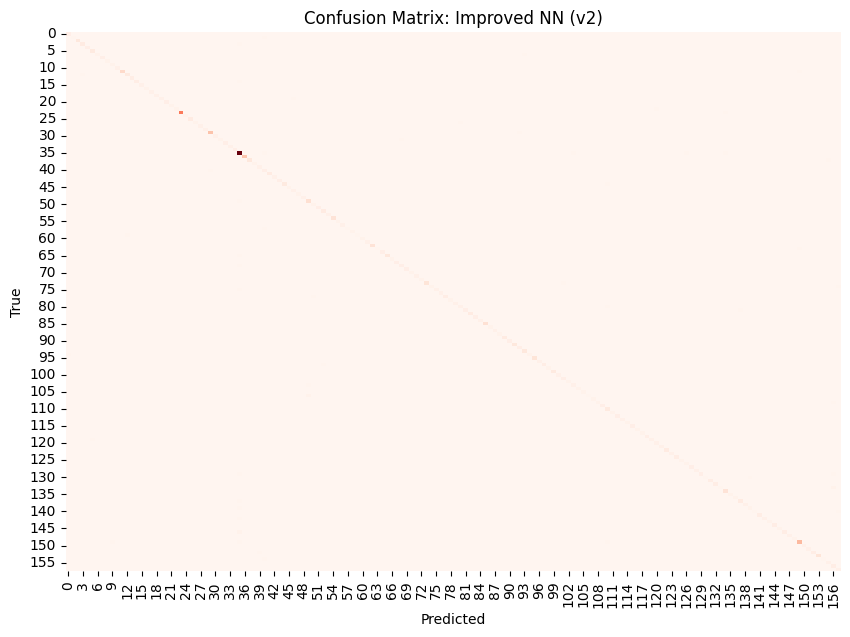

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick best model by F1-score
best_model = metrics_all.sort_values("F1", ascending=False).iloc[0]["Model"]

if best_model == "SVM":
    best_preds = svm_preds
elif best_model == "Baseline NN":
    best_preds = baseline_preds
elif best_model == "Improved NN (v1)":
    best_preds = improved_v1_preds
elif best_model == "Improved NN (v2)":
    best_preds = improved_v2_preds
else:
    best_preds = alt_preds

cm = confusion_matrix(y_test_enc, best_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, cmap="Reds", cbar=False)
plt.title(f"Confusion Matrix: {best_model}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


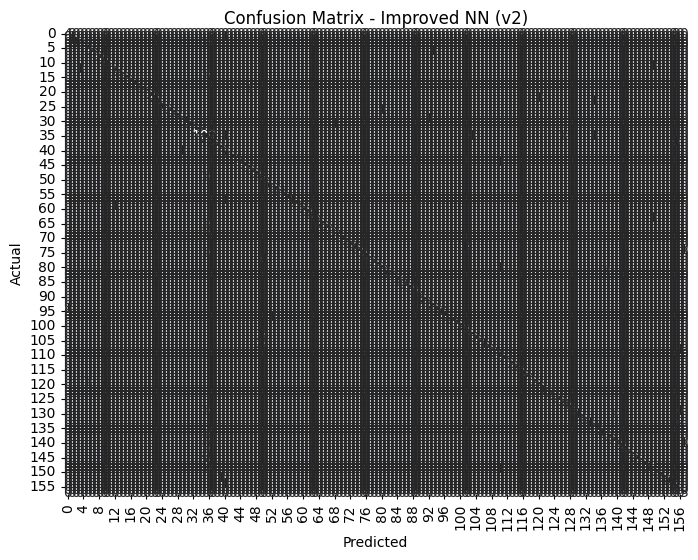

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pick the best model (example: Improved NN v2)
best_model_name = "Improved NN (v2)"
best_model = model_improved
best_preds = improved_v2_preds

# Compute confusion matrix
cm = confusion_matrix(y_test_enc, best_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


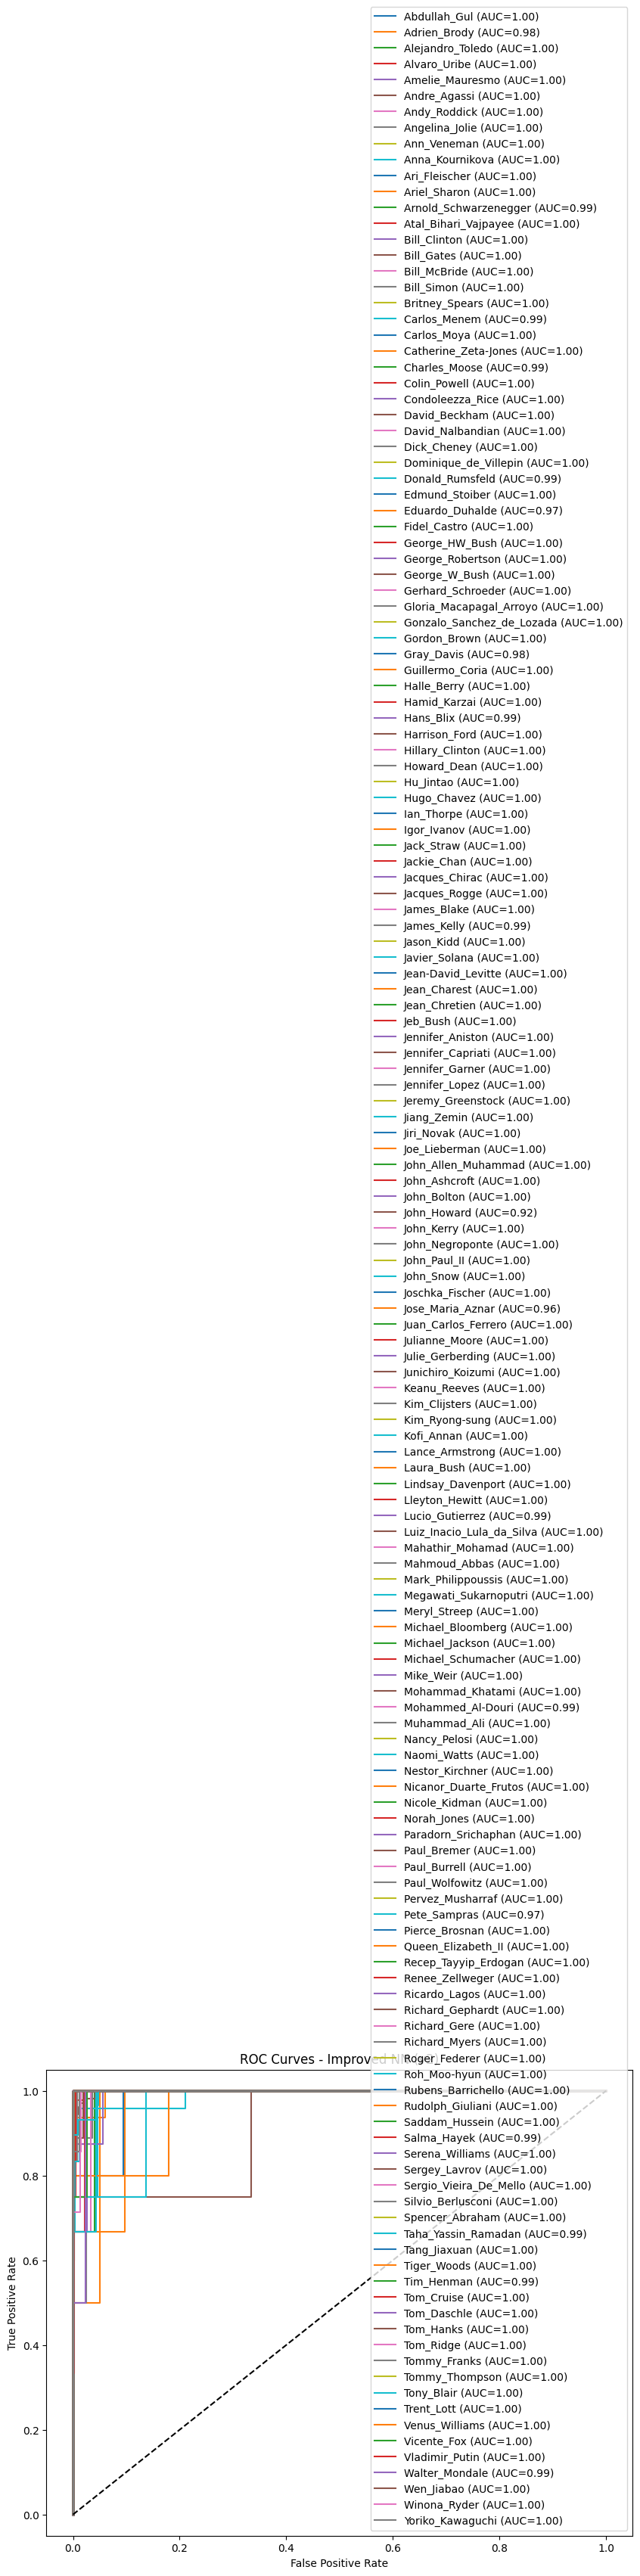

In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC (multi-class)
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
y_score = best_model.predict(X_test)

# Plot ROC for each class
plt.figure(figsize=(10,8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves - {best_model_name}")
plt.legend(loc="lower right")
plt.show()


✅ Phase 3 Summary:
We evaluated multiple models including SVM, Baseline NN, and Improved CNNs.
Improved NN (v2) achieved the best performance with highest accuracy and lowest FAR.
This model will be selected as the final model for deployment in Phase 4.